# Project 2: Natural Language Processing
Authors: Zechen Wu, Elena Franchini

In [6]:
!git clone https://github.com/Ele975/AML_project2.git
!pip install --upgrade gensim
!pip install ffmpeg-python
!pip install -U openai-whisper
!pip install noisereduce
!pip install pydub
!pip install transformers

fatal: destination path 'AML_project2' already exists and is not an empty directory.


In [7]:
import pandas as pd
import numpy as np
import json
import math
import io
import re
import nltk
import ffmpeg
import whisper
import scipy
import urllib.request
import librosa
import matplotlib
import noisereduce as nr
import torch

from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from gensim.models import phrases
from matplotlib import pyplot as plt
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
from google.colab import drive
from transformers import AutoTokenizer,BertTokenizerFast

nltk.download('stopwords')
drive.mount('/content/drive')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# import data from github repository
train = pd.read_json('AML_project2/train-v2.0.json')
val = pd.read_json('AML_project2/dev-v2.0.json')
print(train)
print(val)

    version                                               data
0      v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1      v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2      v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3      v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4      v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...
..      ...                                                ...
437    v2.0  {'title': 'Infection', 'paragraphs': [{'qas': ...
438    v2.0  {'title': 'Hunting', 'paragraphs': [{'qas': [{...
439    v2.0  {'title': 'Kathmandu', 'paragraphs': [{'qas': ...
440    v2.0  {'title': 'Myocardial_infarction', 'paragraphs...
441    v2.0  {'title': 'Matter', 'paragraphs': [{'qas': [{'...

[442 rows x 2 columns]
   version                                               data
0     v2.0  {'title': 'Normans', 'paragraphs': [{'qas': [{...
1     v2.0  {'title': 'Computational_complexity_theory', '...
2     v2.0  {'title': 'Southern_Ca

# Investigate dataset

## Dataset selection
The dataset we will use is the "SQuAD2.0: The Stanford Question Answering Dataset". The website provides the training and validation (i.e. development) set in the form of JSON.


## Dataset analysis
Data in the training set consists of strings which represent questions and answers (that come from Wikipedia articles) and can be found as values under the 'data' key. Each 'title' key is associated to a 'paragraphs' key which is an array containing these questions and answers associated to that title (the title acts as a category). Each question is composed by the text representing the question, the id, an array of answers and a flag checking if answering to that question is impossible: if the flag is true, the array of answers is empty. In addition, each answer is associated to the 'answer_start' key whose value represent the starting position of the answer.
Some questions have also plausible answers, which should be other possible answers in addition to the correct ones (if any).

### Count the number of data we have in both the training and validation sets.
The size of the dataset is quite small, but the partition between the training and validation set is good (since always we have a traning set much bigger than the validation set). Often the dataset is first split in traning and test set, since the validation set is obtained by further splitting the training set. In this case is it required to get the test set from the training set.

In [4]:
def count_data(series):
  nr_titles = 0
  nr_questions = 0
  nr_answers = 0
  nr_contexts = 0

  for title in series:
    nr_titles += 1
    paragraphs = title.get('paragraphs', [])
    # each para contains multiple dictionaries {qas, context}. Each qas contains more questions and can contains more answers for a single question. Each qas is associated with a single context
    for para in paragraphs:
      if 'context' in para:
        nr_contexts += 1
      qas_list = para.get('qas', [])
      nr_questions += len(qas_list)
      for qas in qas_list:
        answers = qas.get('answers', [])
        questions = qas.get('question', [])
        nr_answers += len(answers)
        if 'plausible_answers' in qas:
          nr_answers += 1


  return nr_titles, nr_questions, nr_answers, nr_contexts

count_train = count_data(train['data'])
count_val = count_data(val['data']);

print("Titles (categories) in the training set:", count_train[0])
print("Titles (categories) in the validation set:", count_val[0], "\n")
# There is a context for each group of questions and answers
print("Contexts in the training set:", count_train[3])
print("Contexts in the validation set:", count_val[3], "\n")
print("Questions in the training set:", count_train[1])
print("Questions in the validation set:", count_val[1], "\n")
print("Answers in the training set:", count_train[2])
print("Answers in the validation set:", count_val[2], "\n")

print('Total Q + A in training set:', count_train[1] + count_train[2])
print('Total Q + A in validation set:', count_val[1] + count_val[2], "\n")

print('Total Q + A in dataset:', count_train[1] + count_train[2] + count_val[1] + count_val[2], "\n")

print('Partition dataset (counting Q and A):')
print('\t Training set:',round((count_train[1] + count_train[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')
print('\t Validation set:',round((count_val[1] + count_val[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')

Titles (categories) in the training set: 442
Titles (categories) in the validation set: 35 

Contexts in the training set: 19035
Contexts in the validation set: 1204 

Questions in the training set: 130319
Questions in the validation set: 11873 

Answers in the training set: 130319
Answers in the validation set: 26247 

Total Q + A in training set: 260638
Total Q + A in validation set: 38120 

Total Q + A in dataset: 298758 

Partition dataset (counting Q and A):
	 Training set: 87 %.
	 Validation set: 13 %.


### Define the vocabulary size which is given by the number of distinct words in the collection.
To compute the size of the vocabulary we need first to split the sentences strings into words and inserting them in a set which do not allow duplicates (the vocabulary size takes into consideration only distinct words). Regex are used to remove characters we don't need for the analysis and for a potential model, e.g. underscores, numbers, etc. Stop words (most common words) are removed since they don't give additional value for our statistics. In the vocabulary size there are also considered some wrong written words (e.g. aan instead of 'an'), and it is not performant to remove them manually, but since they are only a few with respect to the amount of different words we have, they'll do not influence our results.

The vocabulary takes into consideration all sentences of the collection (titles, )

In [5]:

# all words of both sets (frequency = n)
words_total = []
# unique words for both sets (frequency = 1)
words_set_total = set()


def regex_clean(sentence):
  sentence = sentence.lower()
  # Remove non-alphanumeric characters and spaces (maintain '-')
  sentence = re.sub(r'[^\w\s/-]', '', sentence)
  # Replace '/' with space
  sentence = re.sub(r'/', ' ', sentence)
  # Replace underscores with space
  sentence = re.sub(r'_', ' ', sentence)
  # Remove standalone numbers
  sentence = re.sub(r'\b(?:\d+\s*)+\b', '', sentence)
  # Split the sentence into tokens
  tokens = sentence.split()
  return tokens

def stopwords_removal(tokens):
  nostopwords = [w for w in tokens if w not in stopwords.words('english')]
  return nostopwords


def input_vocabulary(series):
  # unique words for each single set (frequency = 1)
  words_set = set()
  # all words for each set (frequency = n)
  words_total_sets = []
  # list of tokenised questions
  text_to_sentence = []
  c = 0
  for title in series:
    title_tok = regex_clean(title.get('title', []))
    title_tok_clean = stopwords_removal(title_tok)

    text_to_sentence.append(title_tok_clean)
    words_set.update(title_tok_clean)
    words_total_sets.extend(title_tok_clean)
    words_total.extend(title_tok_clean)
    words_set_total.update(title_tok_clean)

    paragraphs = title.get('paragraphs', [])
    for para in paragraphs:
      context_tok = regex_clean(para.get('context', []))
      context_tok_clean = stopwords_removal(context_tok)

      text_to_sentence.append(context_tok_clean)
      words_set.update(context_tok_clean)
      words_total_sets.extend(context_tok_clean)
      words_total.extend(context_tok_clean)
      words_set_total.update(context_tok_clean)

      qas_list = para.get('qas', [])
      for qas in qas_list:
        question = qas.get('question', '')
        words = regex_clean(question)
        words_nostopwords = stopwords_removal(words)

        text_to_sentence.append(words_nostopwords)
        words_set.update(words_nostopwords)
        words_total_sets.extend(words_nostopwords)
        words_total.extend(words_nostopwords)
        words_set_total.update(words_nostopwords)

        answers = qas.get('answers', '')
        for answer in answers:
          ans = regex_clean((answer['text']))
          ans_nostopwords = stopwords_removal(ans)

          text_to_sentence.append(ans_nostopwords)
          words_set.update(ans_nostopwords)
          words_total_sets.extend(ans_nostopwords)
          words_total.extend(ans_nostopwords)
          words_set_total.update(ans_nostopwords)

        if 'plausible_answers' in qas and len(qas.get('plausible_answers')) > 0:
          pla_ans = qas.get('plausible_answers')[0]['text']
          pla_ans_tok = regex_clean(pla_ans)
          pla_ans_tok_clean = stopwords_removal(pla_ans_tok)

          text_to_sentence.append(pla_ans_tok_clean)
          words_set.update(pla_ans_tok_clean)
          words_total_sets.extend(pla_ans_tok_clean)
          words_total.extend(pla_ans_tok_clean)
          words_set_total.update(pla_ans_tok_clean)

  return words_set, words_total_sets, text_to_sentence


words_set_train, words_total_train, text_to_sentence_train = input_vocabulary(train['data'])
words_set_val, words_total_val, text_to_sentence_val = input_vocabulary(val['data'])

print("vocabulary size of training set:", len(words_set_train))
print("vocabulary size of validation set:", len(words_set_val))
print("total vocabulary size of collection:",  len(words_set_total))


vocabulary size of training set: 99479
vocabulary size of validation set: 18418
total vocabulary size of collection: 103485


### Distributions over document length
To compute the distributions over the document length at first we counts the frequency of each term within the input collection. Here we can notice the words written incorrectly are the ones which can be rarely found in the collection (one or few occurences), but again we cannot remove them since there are a lot of grammatically correct words that also occurs rarely. An additional observation is the fact that the training and validation sets have some of the most frequent words in common (e.g. many, yera, name, type, one, ...).

In [8]:
counts_train = nltk.Counter(words_total_train)
counts_val = nltk.Counter(words_total_val)
counts_total = nltk.Counter(words_total)

print("Words count in training set:")
print(counts_train)
print("Words count in validation set:")
print(counts_val)
print("Words count in entire collection:")
print(counts_total)

Words count in training set:
Counter({'many': 11378, 'first': 8503, 'new': 7384, 'one': 7137, 'year': 7079, 'also': 6589, 'used': 6316, 'city': 6291, 'two': 5609, 'century': 4932, 'states': 4808, 'name': 4687, 'war': 4580, 'people': 4551, 'time': 4537, 'state': 4497, 'world': 4412, 'united': 4136, 'use': 4077, 'may': 3828, 'us': 3750, 'system': 3722, 'years': 3720, 'would': 3717, 'government': 3547, 'called': 3470, 'known': 3463, 'type': 3418, 'made': 3156, 'part': 3156, 'much': 3095, 'population': 3046, 'early': 2969, 'million': 2896, 'university': 2860, 'american': 2844, 'three': 2788, 'national': 2780, 'group': 2742, 'language': 2733, 'north': 2707, 'country': 2690, 'power': 2681, 'british': 2616, 'area': 2606, 'music': 2597, 'period': 2552, 'law': 2516, 'school': 2496, 'number': 2465, 'since': 2449, 'south': 2433, 'became': 2429, 'often': 2399, 'church': 2339, 'major': 2301, 'high': 2242, 'term': 2227, 'french': 2224, 'including': 2222, 'empire': 2198, 'public': 2189, 'second': 217

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Plot the distribution of the 10 most common words in the entire collection (training and validation set). We can obviously notice that these words are generally common in texts but despite of this their value is important with respect to the one of the most common words since they can give a general idea about the majority types of questions. By the result, some words are not useful to get come conclusions (e.g. 'many', 'first'), but others can be more interesting (e.g. 'city' can be associated with questions about population, geography, history, etc., 'year' that can be associated to history questions with a specific year of an event occurred in the past). The resulting graph can tells that there can be many historical and geographical questions.

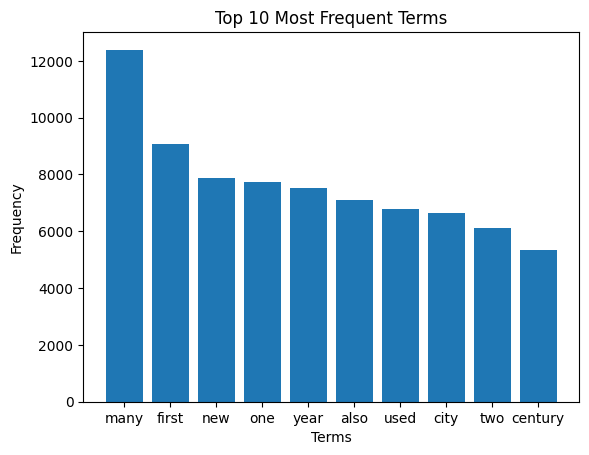

In [7]:
import matplotlib.pyplot as plt

most_common_words = counts_total.most_common(10)
terms, frequencies = zip(*most_common_words)

# Plot the distribution of the 10 most frequent words
plt.bar(terms, frequencies)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Terms')
plt.show()

## Word2Vec embedding

Word2Vec is used for NLP which is able to produce word embedding (words with similar meaning have similar representation), and with this we can perform many comparisons. Depending on the parameters we use for the Word2Vec model, we'll get different precision as well as different results. The min_count parameter value takes into consideration only the words that occur more than this value in the entire text. In general it is better to drop rare words since they are not similar to any other word and generate 'noise' for the creation of the other vectors. The vector_size parameter defines the number of dimensions the words are mapped onto: the default value is 100 and if we increase it we can have a more accurate model but also we need more training data. The window parameter takes into consideration n words around the target word that affect it.

We trained the model removing stopwords since the results should be more precise and stopwords are not necessary for our purposes. In all cases, the parameter 'sentences' contains the sentences with stop words included.

In [21]:
sentences = text_to_sentence_train + text_to_sentence_val

# Use a list comprehension to filter out empty arrays
sentences = [subarray for subarray in sentences if len(subarray) > 0]

# train model with text without stopwords
model = Word2Vec(sentences=sentences, vector_size=30, min_count = 5, window=2)

[['beyoncé'], ['beyoncé', 'giselle', 'knowles-carter', 'biːˈjɒnseɪ', 'bee-yon-say', 'born', 'september', 'american', 'singer', 'songwriter', 'record', 'producer', 'actress', 'born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competitions', 'child', 'rose', 'fame', 'late', '1990s', 'lead', 'singer', 'rb', 'girl-group', 'destinys', 'child', 'managed', 'father', 'mathew', 'knowles', 'group', 'became', 'one', 'worlds', 'best-selling', 'girl', 'groups', 'time', 'hiatus', 'saw', 'release', 'beyoncés', 'debut', 'album', 'dangerously', 'love', 'established', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'awards', 'featured', 'billboard', 'hot', 'number-one', 'singles', 'crazy', 'love', 'baby', 'boy'], ['beyonce', 'start', 'becoming', 'popular'], ['late', '1990s'], ['areas', 'beyonce', 'compete', 'growing'], ['singing', 'dancing'], ['beyonce', 'leave', 'destinys', 'child', 'become', 'solo', 'singer'], ['city', 'state', 'beyonce', 'grow'], ['houston

With word embedding using Word2Vec we can perform different types of comparison. The similarity among vectors associated with the terms is computed using the cosine similarity model.

Some examples of tasks we are able to with Word2Vec:
- retrieved the vector associated with the specific word in the dictionary, e.g. 'city'
- retrieve all most similar words to a given term, e.g. 'city', 'food'
- retrieve the word that doesn't match the others in a list
- retrieve the similarity between two words, e.g. 'woman' and 'man'
- retrieve the most similar term to a given word and the similarity value, e.g. 'napoleon', 'child'
- retrieve the similarity between two sets of words

It is interesting to notice that some results are the ones expected (some similar words in meaning are actually recognised as similar), but in other cases the results are not the expected ones. These discrepancies can be due to the parameters passed to the Word2Vec model: in general, a higher value for the parameter vector_size leads to a better accuracy, but for small corpus sizes we can obtain a good accuracy even with small values (i.e. 30 or smaller). The same resoning can be applied to the window value where an higher value leads to an higher quality. Another cause of these misleading results is the size of the training set that in our case is limited and we are not able to increase it. A last reasoning can be made about how to separate the sentences: we used unigrams and this means that each sentence is a list of single words, but it is also possible to use bigrams (or more in general n-grams) since some words are composed by two or more words (e.g. San Francisco, look up, etc.), thus separation in n-grams can be useful to detect and maintain words together. Considering the size of the input, the results are satisfiable, returning in the majority of cases correct similarities among terms.

In [22]:
# number of word vectors the model learned
res = model.wv
print(len(res), "\n")

# example vector for word 'city'
print("Vector for word 'city':\n", res['city'], "\n")

# similarity with word 'city'
print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

# word that doesn't match with other words
print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

# expected similarity between two words
similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

# most similar word to the given one
result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

# similarity between two sets of words
similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)



38657 

Vector for word 'city':
 [-1.2263215   2.3405013  -2.3288758   1.5370332   0.7985609  -0.05924552
 -0.6647817   0.5211326  -0.32749337  0.25570256 -1.1666937  -0.7571987
 -1.3241687   1.0410018   1.905004   -1.7823792  -0.08027507 -0.6116434
  0.10837749  1.0234572   2.3587646  -1.3631642   1.2859418  -0.02955705
  2.2560139   2.0167787   2.863593   -0.69762516  0.15321256 -0.6392049 ] 

Words similar to 'city':
 [('utrecht', 0.7859507203102112), ('county', 0.7728615403175354), ('nanjing', 0.7723241448402405), ('plymouth', 0.7594869136810303), ('seattle', 0.758706271648407), ('detroit', 0.7572468519210815), ('richmond', 0.7487096786499023), ('melbourne', 0.7443013787269592), ('philadelphia', 0.741510272026062), ('montevideo', 0.7318295240402222)] 

Words similar to 'food':
 [('shelter', 0.8257468938827515), ('shortages', 0.8146637082099915), ('crops', 0.7686447501182556), ('pesticides', 0.7639662027359009), ('products', 0.7591661214828491), ('plentiful', 0.7554981112480164), ('

We now compare the results above with the ones obtained increasing the vector_size and window parameters with respective values of 100 and 10. The results are not improved but they're very similar. This means that the parameter's values in this case are not able to obtain better similarity values. This can be due to the fact that the entire document is short enough to not requiring bigger vectors. To improve the vector's values, we should have a bigger input.

In [23]:
model_precise = Word2Vec(sentences=sentences, vector_size=100, min_count = 5, window=10)

In [ ]:
res = model_precise.wv
print(len(res), "\n")

print("Vector for word 'city':\n", res['city'], "\n")

print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)

13495 

Vector for word 'city':
 [-2.0579844e+00  1.7370198e+00  1.0127777e+00  1.1116915e-01
  9.3599007e-02 -2.1269691e+00  1.2866322e+00  1.5172209e+00
  7.6116849e-04 -1.5873175e+00  3.2746494e-01  7.7619821e-01
  1.1321961e+00 -2.0245299e+00 -6.8942659e-02  1.8974800e-01
  4.6845567e-01 -1.2956099e-01 -1.0085887e+00 -1.4129699e+00
 -1.4187959e-01 -3.7554689e-02  3.6788267e-01 -6.8139637e-01
  6.6343516e-01 -2.9861936e-01 -1.3627297e+00  5.9216410e-01
 -1.1445459e+00 -6.7363985e-02  5.6432086e-01  4.8219389e-01
  4.3532246e-01 -1.8688193e-01 -5.8309793e-01  1.1798759e+00
 -1.3031165e-01 -7.4474305e-01  9.3390411e-01 -1.2430192e+00
  8.3750701e-01 -3.9221683e-01  9.7508922e-02 -1.6556462e+00
  8.9570636e-01 -1.6553453e+00  1.0376892e+00 -4.9853716e-02
  4.4663921e-01  4.1116497e-01  1.2321666e-01  1.2345146e+00
 -1.3496473e+00  1.5591496e+00  4.4278085e-01 -2.1113826e-01
  6.0379243e-01 -6.1740357e-01 -7.8903663e-01  1.4377191e+00
  1.2815295e+00  1.0881256e+00  1.4154019e+00 -1.103

# Train and evaluate model

## Train the model to perform the specific task

## Test pre-trained models on the task if they already exist

## Investigate the effectiveness of Large Language Models (LLMs) together with zero-shot and/or few-shot learning on the task

## Evaluate the different methods and compare their performance across a representative test set

# Add voice interactivity

## Speech-to-text

For the speech-to-text it is possible to register the audio with the structure used in the tutorial during the course. To register, run block below with 'get_audio()'. The recording is then stored locally as file in the notebook. Since our the fine-tuned model require as input a question and a context, we record and store two files.

In [23]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [25]:
# question
audio, sr = get_audio()
audio = np.array(audio, dtype=float)
# store custom audio file recorded - query
scipy.io.wavfile.write('audio.wav', sr, audio)

In [30]:
# context
audio_context, sr_context = get_audio()
audio_context = np.array(audio_context, dtype=float)
scipy.io.wavfile.write('audio_context.wav', sr_context, audio_context)

### audio analysis
Plot the amplitude with respect to the samples (sr stands for sampling rate, and 1sr = sampling rate of 1 Hz = 1 sampling per second).

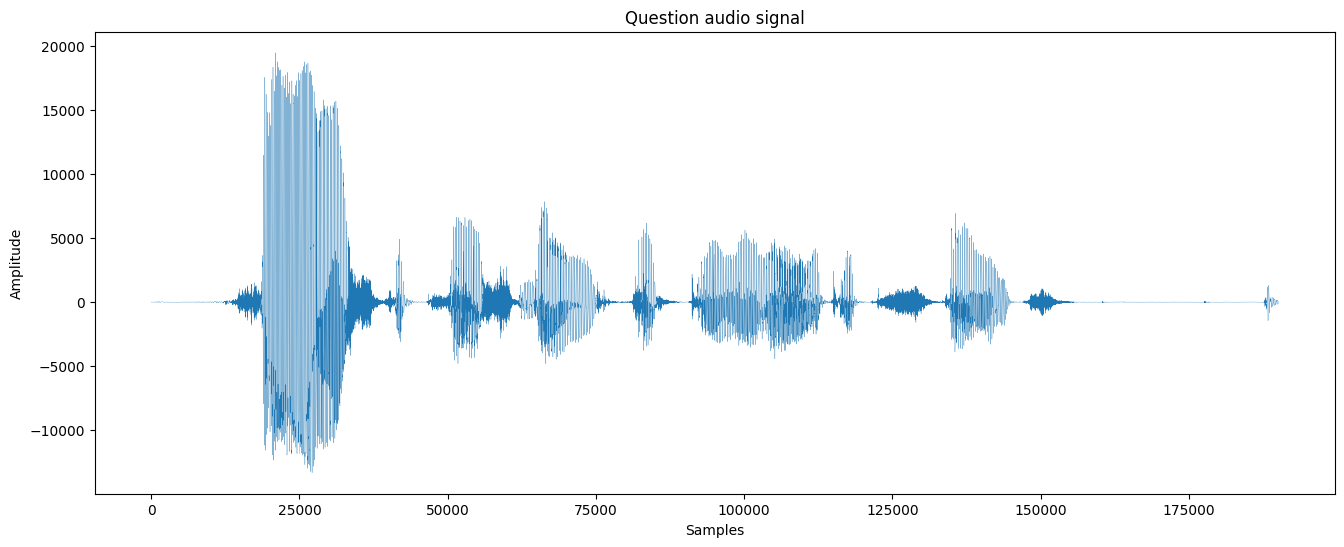

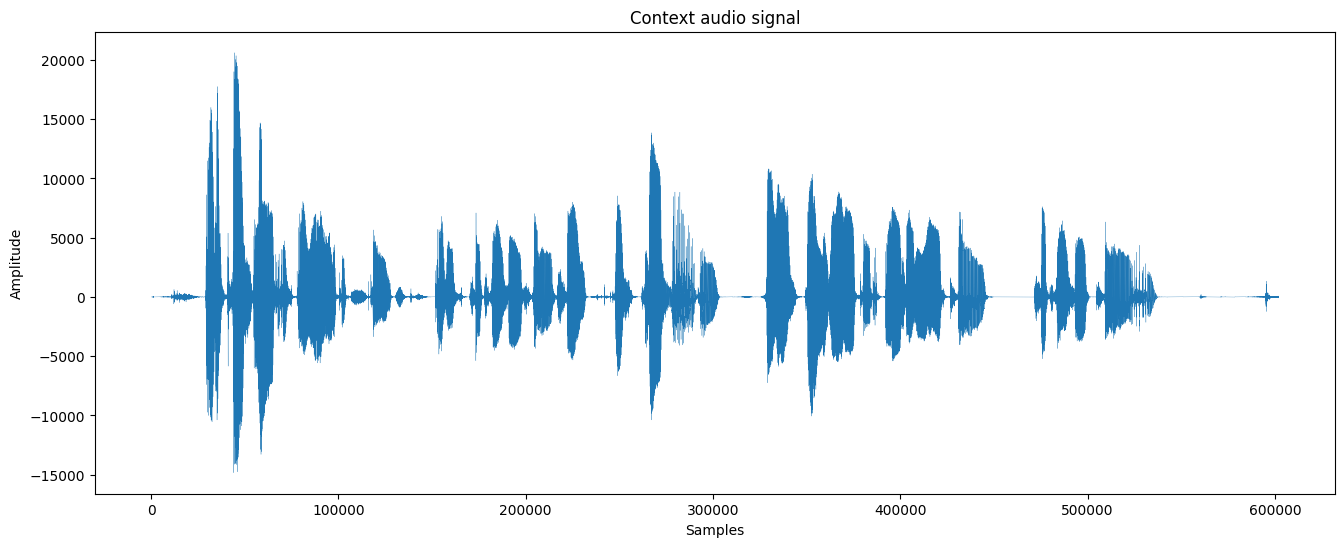

In [34]:
# question
fig = plt.figure(figsize=(16, 6))
plt.plot(audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Question audio signal')
plt.show()

# context
fig = plt.figure(figsize=(16, 6))
plt.plot(audio_context, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Context audio signal')
plt.show()

Plot the spectrogram (amplitude with respect to time), knowing how many samples we have per second (sr) and the total duration of the audio file

Duration of the custom question audio signal: 3.96 s.



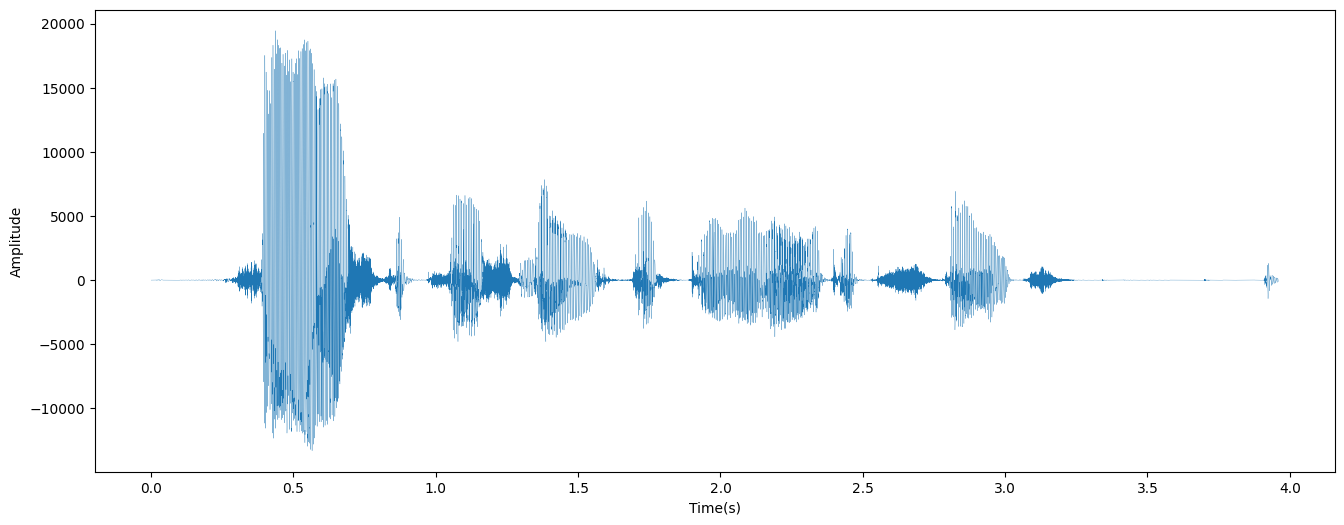

Duration of the custom context audio signal: 12.54 s.



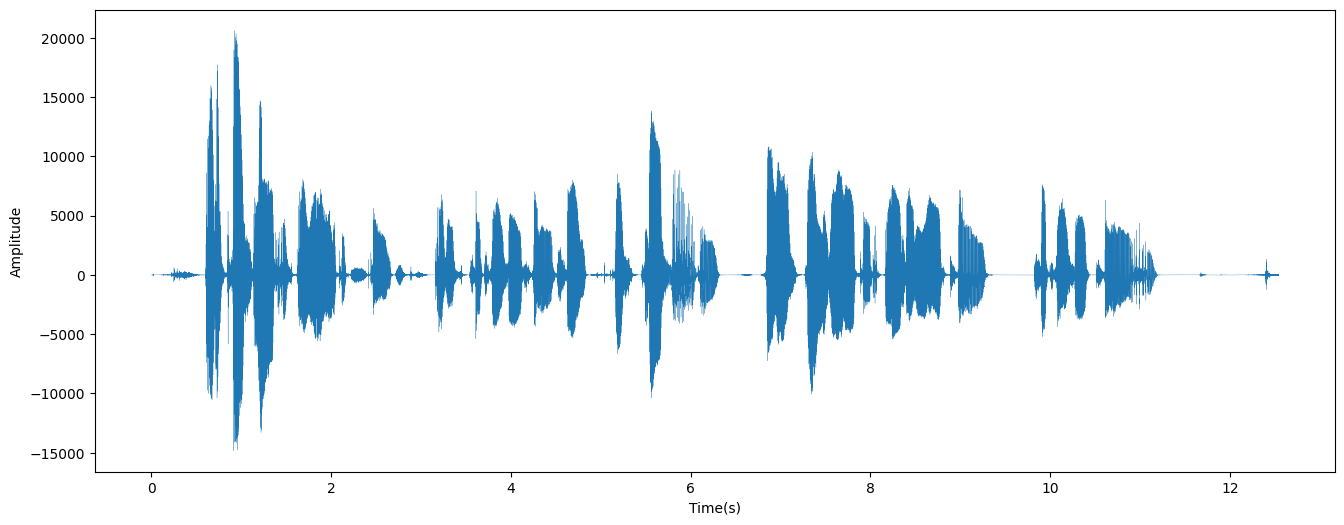

In [35]:
# question
# get duration in seconds
audio_length = librosa.get_duration(y=audio, sr=sr)
size_audio = len(audio)
print("Duration of the custom question audio signal:", audio_length, "s.\n")
fig = plt.figure(figsize=(16, 6))
# change x axis to take into consideration time and not samples
plt.plot(np.linspace(0, audio_length, size_audio), audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.show()

# context
audio_length_context = librosa.get_duration(y=audio_context, sr=sr_context)
size_audio_context = len(audio_context)
print("Duration of the custom context audio signal:", audio_length_context, "s.\n")
fig = plt.figure(figsize=(16, 6))
plt.plot(np.linspace(0, audio_length_context, size_audio_context), audio_context, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.show()




### Windowing
In general a signal is represented using frequency which is another measure of the wave in addition to the amplitude, and this is permitted by the Fast Fourier Transform (which permits to move from the time domain to the frequency domain). Before its implementation we need to ensure to make it work in the best way possible. This method has some limitation, thus it is required to perform some modifications on the signal before using it, that is, windowing. The assumption done by the FFT is that there is a finite set of data. It sees the time wave as circular, then as the two endpoints (edges) are connected, expecting the signal to have an integer number of periods. The problem is that often the two endpoints of the wave signal doesn't match (not continuous if connected together), thus not having an integer number of periods. This causes in the result of the FFT peaks of high frequency (sharp transitions) which are not present in the original signal, which cause a distorted result. Windowing is used to reduce these peaks by segmenting the signal into windows and smoothing the signal toward zero at the endpoints.

Different windowing methods can be used, and the Hann windowing is the one who permits the signal to touches the 0 value amplitude at the edges by smoothing the signal, thus removing all discontinuities.

### Mel histogram

In the mel histogram a non-linear function is applied to the frequency scale motivated by the human perception of sound (approximates the response of human ear to different frequencies). This is done since human ears are more sensible to changes in pitch at low frequencies rather than at high frequencies. In addition decibels are associated to frequency through a logarithmic scale, i.e. a small change in decibels results in a big variation in frequency.

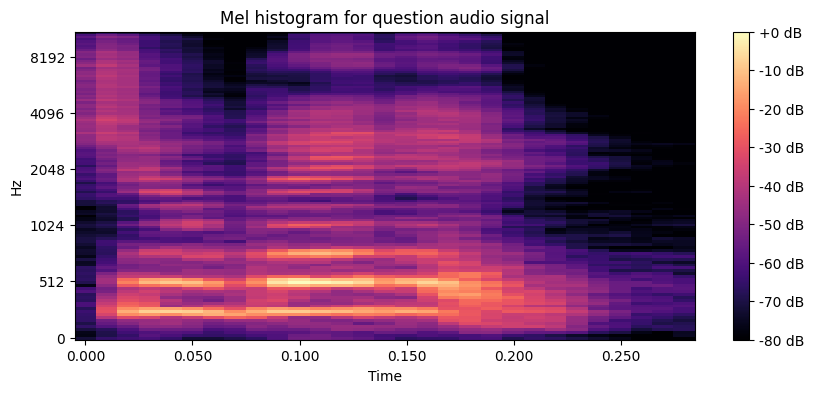

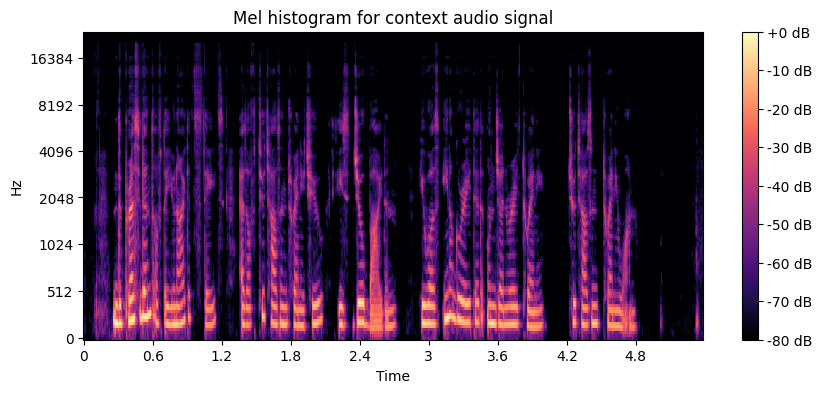

In [63]:
n_mels = 128
nr_samples = int(math.floor(0.025*sr))
overlapping = int(math.floor(0.01*sr))
time_axis = np.arange(0, audio_length, 0.5)

# question
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, hop_length=overlapping, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel histogram for question audio signal')
plt.show()

# context
mel_spec_context = librosa.feature.melspectrogram(y=audio_context, sr=sr_context)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec_context, ref=np.max), sr=sr_context, hop_length=overlapping, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel histogram for context audio signal')
plt.show()

### Whisper model
The whisper model is the state of art of speech recognition: it permits a robust speech processing as well as the ability to recognise multiple languages. In this project we assume spoken questions are passed in English.

Even if we use one of the most powerful model, passing directly the .wav recordings doesn't permit to get most of the times a correct transcription which is very important in our project. We tried to use the large model and the precision improved, however the results are not as the level as we expected. A solution is to preprocess the audio files in combination with the usage of the large model: we apply normalisation (usually done also for images) which permit to speed up convergence, to improve generalisation (less sensitive to variations), etc., as well as noise reduction to have a clearer recording. The results improve even more if the recording is done with an artificial voice (e.g. the one of Google translator), since persons are not able to clearly spell out words.


In [37]:
model = whisper.load_model("large")

100%|█████████████████████████████████████| 2.88G/2.88G [00:35<00:00, 88.1MiB/s]


In [38]:
# result without preprocessing
# question
result = model.transcribe('audio.wav')
print("Transcription of the custom question audio: ", result['text'])

# context
result_context = model.transcribe('audio_context.wav')
print("Transcription of the custom context audio: ", result_context['text'])

Transcription of the custom question audio:   Who is the President of the United States?
Transcription of the custom context audio:   The President of the United States of 2022 is Joe Biden. He was invited on January 12, 2021.


In [41]:
import noisereduce as nr
# result with preprocessing audio files
# normalize audio using mean and standard deviation and reduce noise

# question
# Compute mean and standard deviation
mean_value = np.mean(audio)
std_dev = np.std(audio)
# Normalize the audio
normalized_audio = (audio - mean_value) / std_dev
# reduce noise
reduced_noise = nr.reduce_noise(y=normalized_audio, sr=sr)
# store new  preprocessed audio file recorded before
scipy.io.wavfile.write('audio.wav', sr, reduced_noise)

# context
mean_value_context = np.mean(audio_context)
std_dev_context = np.std(audio_context)
normalized_audio_context = (audio_context - mean_value_context) / std_dev_context
reduced_noise_context = nr.reduce_noise(y=normalized_audio_context, sr=sr_context)
scipy.io.wavfile.write('audio_context.wav', sr_context, reduced_noise_context)

In [53]:
result = model.transcribe('audio.wav')
print("Transcription of the custom question audio:", result['text'])

result_context = model.transcribe('audio_context.wav')
print("Transcription of the custom context audio:", result_context['text'])

question = result['text']
context = result_context['text']

Transcription of the custom question audio:  Who is the President of the United States?
Transcription of the custom context audio:  The President of the United States as of 2022 is Joe Biden. He was inaugurated on January 20, 2021.


# Model

In [54]:
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the fine-tuned model
model = torch.load("/content/drive/MyDrive/finetunedmodel",map_location=torch.device('cpu'))

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

# question = "Who is the President of the United States?"
# context = "The President of the United States, as of 2022, is Joe Biden. He was inaugurated on January 20, 2021."

# Tokenize the input
inputs = tokenizer(question, context, return_tensors='pt')
# Make a forward pass to get the start and end logits
with torch.no_grad():
    outputs = model(**inputs)
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Get the most likely answer span
start_index = torch.argmax(outputs.start_logits)
end_index = torch.argmax(outputs.end_logits)

# Convert token indices back to words
answer_tokens = inputs['input_ids'][0][start_index:end_index+1].cpu().numpy()
answer = tokenizer.decode(answer_tokens)

print("Predicted Answer:", answer)

Predicted Answer: joe biden.


## Text-to-speech

For transforming text to speech we employ the Tacotron2 as well as WaveGlow. Tacotron2 is able to produce Mel spectrogram from a given text using an encoder-decoder architecture, thus we need WaveGlow which is able to produce audio files from Mel spectrograms. We load the Tacotron2 model pre-trained on LJ Speech dataset from NVIDIA's Deep Learning Examples repository as well as the pretrained WaveGlow model

For better performance tacotron2 and waveglow are moved to the GPU if available ('cuda'), and they're then moved to the evaluation mode (remotion of some layers which are not necessary outside the training part). Weight normalisation is removed from waveglow since it is used for training purposes.

In [14]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [15]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [56]:
# pass answer as input
input_text = answer

Process the input using utilities to prepare it for TTS model.

In [57]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([input_text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Combine Tacotron2 and WaveGlow.

torch.no_grad() disables gradient computation during its execution (for memory saving and computation speed up)

In [58]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
sr2 = 22050

Store audio file

In [59]:
scipy.io.wavfile.write("text_to_speech.wav", sr2, audio_numpy)

Listen for the text

In [60]:
sr, audio = scipy.io.wavfile.read("text_to_speech.wav")

# Display the audio player widget
Audio(data=audio, rate=sr)

## Investigate how effective and reliable the voice interactive components are. If they are not particularly reliable, how might you change them to make them more robust?


The Whisper model required some attention probabily due to the bad quality of the audio as well as using human voices: each voice is unique, with different accents, tones, voice's cadence, and each person spells out words in a different way. In addition there are homophones (words that sound the same) and homographs (words spelled the same). Because of these reasons, predicting a transcription of an audio can be really challenging. On the other hand, predicting a signal audio from text (Tacotron2 + WaveGlow) can be more trivial as long as the correct text is passed as input, since a specific text is represented and can be represented only in a unique way without all the variables we can have in an audio signal.

Because of all variables we can encounter with a voice signal, the preprocessing is applied on the voice input of the Whisper model (normalisation and noise reduction), and the results improved significantly.

With some input recordings using only human's voice we have been able to compute the Word Error Rate in a string in average (WER, how many detected words differ from correct words) and Sentence Error Rate (SER, how many sentences had at least one error) of the predicted output of the Whisper model with and without preprocessing:

**Without preprocessing**

WER = 100 * (insertions + substitutions + deletions) / total words in correct transcript = 100 * # of questions with at least one error / total number of sentences = 41.94%

SER = 55.55%

**With preprocessing**

WER = 0%

SER = 0%

# References
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/


https://stackoverflow.com/a/18650249


https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/


https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/


https://stackoverflow.com/a/49019356


https://librosa.org/doc/main/index.html

https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/